In [1]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! conda install -c conda-forge jupyterlab mpi4py impi_rt
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 statsmodels h5pyd seaborn pyarrow memory_profiler

#%load_ext memory_profiler
from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve, imputing
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import platform
import os
import re
import pandas as pd

[ahenry-39583s:01190] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T//ompi.ahenry-39583s.159331683/jf.0/3366846464/sm_segment.ahenry-39583s.159331683.c8ae0000.0 could be created.
/Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-16 09:18:11,772 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/h5pyd/version.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _exp = _sv(version)



## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [2]:
PLOT = False
RELOAD_DATA = True

if platform == "darwin":
    DATA_DIR = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    # PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.parquet"
    # FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/short_kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.202203*.*.*.nc"
    MULTIPROCESSOR = "cf"
    TURBINE_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
elif platform == "linux":
    DATA_DIR = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    PL_SAVE_PATH = "/scratch/alpine/aohe7145/awaken_data/kp.turbine.zo2.b0.raw.parquet"
    FILE_SIGNATURE = "kp.turbine.z02.b0.*.*.*.nc"
    MULTIPROCESSOR = "mpi"
    TURBINE_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/ge_282_127.yaml"
    FARM_INPUT_FILEPATH = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/gch_KP_v4.yaml"

DT = 5

data_loader = DataLoader(data_dir=DATA_DIR, file_signature=FILE_SIGNATURE, multiprocessor=MULTIPROCESSOR, save_path=PL_SAVE_PATH, dt=DT,
                         features=["time", "turbine_id", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"])

In [3]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

2024-10-16 09:18:12,740 - INFO - NetCDF File: kp.turbine.z02.b0.20220316.000000.wt033.nc
2024-10-16 09:18:12,741 - INFO - 
Global Attributes:
2024-10-16 09:18:12,742 - INFO - 
Dimensions:
2024-10-16 09:18:12,742 - INFO -   date: 39242
2024-10-16 09:18:12,743 - INFO -   string7: 7
2024-10-16 09:18:12,743 - INFO - 
Variables:
2024-10-16 09:18:12,744 - INFO -   Flag:
2024-10-16 09:18:12,745 - INFO -     Dimensions: ('date', 'string7')
2024-10-16 09:18:12,745 - INFO -     Shape: (39242, 7)
2024-10-16 09:18:12,747 - INFO -     Data type: |S1
2024-10-16 09:18:12,747 - INFO -     Attributes:
2024-10-16 09:18:12,757 - INFO -       _Encoding: utf-8
2024-10-16 09:18:12,758 - INFO -   date:
2024-10-16 09:18:12,759 - INFO -     Dimensions: ('date',)
2024-10-16 09:18:12,760 - INFO -     Shape: (39242,)
2024-10-16 09:18:12,761 - INFO -     Data type: int32
2024-10-16 09:18:12,761 - INFO -     Attributes:
2024-10-16 09:18:12,762 - INFO -       units: milliseconds since 2022-03-16 20:18:28.499000
2024

In [4]:
if not RELOAD_DATA and os.path.exists(data_loader.save_path):
    # Note that the order of the columns in the provided schema must match the order of the columns in the CSV being read.
    
    schema = pl.Schema({**{"time": pl.Datetime(time_unit="ms")},
                        **{
                            f"{feat}_{tid}": pl.Float64
                            for feat in ["turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"] 
                            for tid in [f"wt{d+1:03d}" for d in range(88)]}
                        })
    
    df_query = pl.scan_parquet(source=data_loader.save_path, hive_schema=schema)
else:
    df_query = data_loader.read_multi_netcdf()

[ahenry-39583s:01309] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T//ompi.ahenry-39583s.159331683/jf.0/2130116608/sm_segment.ahenry-39583s.159331683.7ef70000.0 could be created.
[ahenry-39583s:01310] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T//ompi.ahenry-39583s.159331683/jf.0/100990976/sm_segment.ahenry-39583s.159331683.6050000.0 could be created.
[ahenry-39583s:01308] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk42pk4dgr4qydb3/T//ompi.ahenry-39583s.159331683/jf.0/218890240/sm_segment.ahenry-39583s.159331683.d0c0000.0 could be created.
2024-10-16 09:18:20,118 - INFO - Processed /Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.z02.b0.20220325.000000.wt028.nc
[ahenry-39583s:01315] shmem: mmap: an error occurred while determining whether or not /var/folders/15/zl_rr3g10_b5j7bk

## Plot Wind Farm, Data Distributions

In [5]:
data_inspector = DataInspector(turbine_input_filepath=TURBINE_INPUT_FILEPATH, farm_input_filepath=FARM_INPUT_FILEPATH)

In [6]:
if PLOT and False:
    data_inspector.plot_wind_farm()

In [7]:
if PLOT:
    data_inspector.plot_wind_speed_power(df_query, turbine_ids=["wt073"])

In [8]:
if PLOT:
    data_inspector.plot_wind_speed_weibull(df_query, turbine_ids=["wt073"])

In [9]:
if PLOT:
    data_inspector.plot_wind_rose(df_query, turbine_ids=["wt073"])

In [10]:
if PLOT:
    data_inspector.plot_correlation(df_query, 
    np.concatenate([[f"wind_speed_{tid}", f"wind_direction_{tid}", f"nacelle_direction_{tid}"] for tid in ["wt073"]]))

In [11]:
if PLOT:
    data_inspector.plot_boxplot_wind_speed_direction(df_query, turbine_ids=["wt073"])

In [12]:
if PLOT:
    data_inspector.plot_time_series(df_query, turbine_ids=["wt073"])

## OpenOA Data Preparation & Inspection

In [13]:
def get_features(df, feature_types, turbine_ids="all"):
    if feature_types is not None and not isinstance(feature_types, list):
        feature_types = [feature_types]

    if turbine_ids == "all":
        return sorted([col for col in df.collect_schema().names() if any(feat in col for feat in feature_types)])
    else:
        return sorted([col for col in df.collect_schema().names() if any(feat in col and tid in col for feat in feature_types for tid in turbine_ids)])

ws_cols = get_features(df_query, "wind_speed")
wd_cols = get_features(df_query, "wind_direction")
pwr_cols = get_features(df_query, "power_output")

In [14]:
def collect_data(df, feature_types=None, turbine_ids="all", mask=None, to_pandas=True):
    if feature_types is not None and not isinstance(feature_types, list):
        feature_types = [feature_types]

    if feature_types is not None:
        df = df.select([pl.col(feat) for feat in get_features(df, feature_types, turbine_ids)])
    
    if mask is not None:
        df = df.filter(mask)

    if to_pandas:
        return df.collect(streaming=True).to_pandas()
    else:
        return df.collect(streaming=True)

### Functions to compute similarity between datasets

In [15]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h / data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0] != 0) & (x[1] != 0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    m = (1./2.) * (p + q)
    return (1./2.) * kl_divergence(p, m) + (1./2.) * kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

def compute_js_divergence(train_sample, test_sample, n_bins=100): 
    """
    Computes the JS Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return js_divergence(p, q)


In [16]:
print(f"Features of interest = {data_loader.features}")
cols = df_query.collect_schema().names()
print(f"Available features = {cols}")
# qa.describe(collect_data(df=df_query))

available_turbines = sorted(np.unique([re.findall(f"(?<=wind_direction_)(.*)", col)[0] for col in cols if "wind_direction" in col]))
available_turbines

Features of interest = ['time', 'turbine_id', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['time', 'turbine_status_wt028', 'turbine_status_wt033', 'turbine_status_wt073', 'wind_direction_wt028', 'wind_direction_wt033', 'wind_direction_wt073', 'wind_speed_wt028', 'wind_speed_wt033', 'wind_speed_wt073', 'power_output_wt028', 'power_output_wt033', 'power_output_wt073', 'nacelle_direction_wt028', 'nacelle_direction_wt033', 'nacelle_direction_wt073']


['wt028', 'wt033', 'wt073']

In [17]:
if PLOT:
    plot.column_histograms(collect_data(df=df_query, 
    feature_types=sorted(get_features(df_query, ["wind_speed", "wind_direction", "power_output", "nacelle_direction"], ["wt073", "wt028", "wt033"]))))

In [18]:
data_filter = DataFilter(turbine_availability_col=None, turbine_status_col="turbine_status")

### Remove Inoperational Turbine Rows

2024-10-16 09:21:06,963 - WARNING - /Users/ahenry/miniconda3/envs/wind_forecasting_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(



JS Score for Turbine wt028 Wind Speed = 0.006187799601757506
JS Score for Turbine wt028 Wind Direction = 0.003551823175139578
JS Score for Turbine wt033 Wind Speed = 0.006674385174051825
JS Score for Turbine wt033 Wind Direction = 0.0032823078176376017
JS Score for Turbine wt073 Wind Speed = 0.006981501026235623
JS Score for Turbine wt073 Wind Direction = 0.003970987317358354


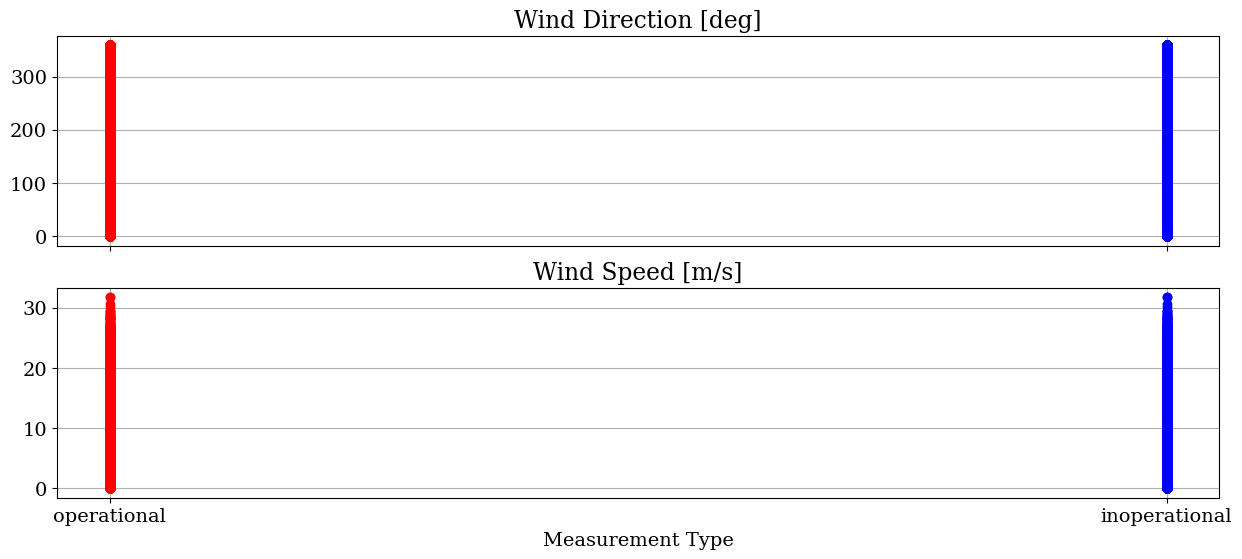

In [19]:
# check if wind speed/dir measurements from inoperational turbines differ from fully operational 
# df_query_op = data_filter.filter_inoperational(df_query, status_codes=[1], include_nan=False)
# df_query_inop = data_filter.filter_inoperational(df_query, status_codes=[2,3,4,5], include_nan=False)


fig, ax = plt.subplots(2, 1, sharex=True)
t_idx = 0
status_codes = [1]
tid = ws_cols[t_idx].split("_")[-1]
df_query_op = df_query.filter(pl.col(f"turbine_status_{tid}").is_in(status_codes)).select([ws_cols[t_idx], wd_cols[t_idx]])
# df_query_inop = df_query.filter(~(pl.col(f"turbine_status_{tid}").is_in(status_codes)) & pl.col(f"turbine_status_{tid}").is_not_null()).select([ws_cols[t_idx], wd_cols[t_idx]])
df_query_all = df_query.select([ws_cols[t_idx], wd_cols[t_idx]])
y = df_query_op.select(wd_cols[t_idx]).collect(streaming=True).to_numpy().flatten()
ax[0].scatter(x=["operational"] * y.shape[0], y=y, color="red")
y = df_query_all.select(wd_cols[t_idx]).collect(streaming=True).to_numpy().flatten()
ax[0].scatter(x=["inoperational"] * y.shape[0], y=y, color="blue", label="inoperational measurements")

y = df_query_op.select(ws_cols[t_idx]).collect(streaming=True).to_numpy().flatten()
ax[1].scatter(x=["operational"] * y.shape[0], y=y, color="red")
y = df_query_all.select(ws_cols[t_idx]).collect(streaming=True).to_numpy().flatten()
ax[1].scatter(x=["inoperational"] * y.shape[0], y=y, color="blue", label="inoperational measurements")
del y

ax[1].set_xlabel("Measurement Type")
ax[0].set_title("Wind Direction [deg]")
ax[1].set_title("Wind Speed [m/s]")

# loop through each turbine's wind speed and wind direction columns, and compare the distribution of data with and without the inoperational turbines
threshold = 0.05
mask = lambda tid: pl.col(f"turbine_status_{tid}").is_in(status_codes) | pl.col(f"turbine_status_{tid}").is_null()
def compute_wind_js_scores(df, threshold, mask, cols):
    for col in cols:
        tid = col.split("_")[-1]
        js_score = compute_js_divergence(
            train_sample=df.filter(mask(tid)).select(col).drop_nulls().collect(streaming=True).to_numpy().flatten(),
            test_sample=df.select(col).drop_nulls().collect(streaming=True).to_numpy().flatten()
            )
        
        if js_score > threshold:
            df = df.with_columns(pl.when(mask(tid)).then(col).alias(col))

        print(f"JS Score for feature {col} = {js_score}")

compute_wind_js_scores(df_query, threshold, mask, ws_cols + wd_cols)
    
    

### Unpivot LazyFrame into Long Form with `turbine_id` Column

In [20]:
# unpivot into long form
if False:
    df_query = pl.concat([
        df_query.select(pl.col("time"), cs.starts_with(feature_type))\
        .filter(pl.any_horizontal(pl.all().is_null()))\
        .unpivot(index="time", value_name=feature_type)\
        .with_columns(pl.col("variable").str.slice(-5).alias("turbine_id"))\
        .drop("variable") for feature_type in ["wind_speed", "wind_direction", "turbine_status", "power_output"]], how="diagonal")\
            .group_by("time", "turbine_id").agg(cs.numeric().drop_nulls().first()).sort("turbine_id", "time")

### Wind Speed Range Filter

In [ ]:
# TODO check if wind speed/dir measurements from inoperational turbines differ from fully operational 
# check for wind speed values that are outside of the acceptable range
ws = collect_data(df=df_query, feature_types="wind_speed")["wind_speed"]
out_of_range = (filters.range_flag(ws, lower=0, upper=70)  & ~ws.isna()).values # TODO does range flag include null/nan values?
del ws
qa.describe(collect_data(df=df_query, feature_types="wind_speed", mask=np.any(out_of_range, axis=1)))

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_query.select(ws_cols[0]).filter(~out_of_range[:, 0]).collect(streaming=True).to_numpy(), 
y=df_query.select(wd_cols[0]).filter(~out_of_range[:, 0]).collect(streaming=True).to_numpy(), color="red", label="in_range measurements")
ax.scatter(x=df_query.select(ws_cols[0]).filter(out_of_range[:, 0]).collect(streaming=True).to_numpy(), 
y=df_query.select(wd_cols[0]).filter(out_of_range[:, 0]).collect(streaming=True).to_numpy(), color="blue", label="out_of_range measurements")
ax.legend()

for t_idx, col in enumerate(ws_cols):
    turbine_id = col.split("_")[-1]
    pc_frozen_vals = 100 * (collect_data(df=df_query, feature_types="wind_speed", turbine_ids=[turbine_id], mask=out_of_range[:, t_idx]).shape[0] 
    / collect_data(df=df_query, feature_types="wind_speed", turbine_ids=[turbine_id], mask=pl.all().is_not_null()).shape[0])
    print(f"Feature wind_speed for turbine {tid} has {pc_frozen_vals} % out of range values.")

In [30]:
# TODO fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# df_query = df_query.with_columns(pl.when(out_of_range).)
df_query = df_query.with_columns(
                [pl.when(~out_of_range[:, t_idx]).then(pl.col(col)).otherwise(np.nan).alias(col)
                for t_idx, col in enumerate(ws_cols)]
                )

In [31]:
del out_of_range

### Power Curve Window Range Filter

In [ ]:
# wind speed measurements will be impacted, unsure how much, 
# TODO check if wind speed/dir measurements from inoperational turbines differ from fully operational
# identifies when turbine is shut down, filtering for normal turbine operation
# apply a window range filter to remove data with power values outside of the window from 20 to 3000 kW for wind speeds between 5 and 40 m/s.

out_of_window = filters.window_range_flag(window_col=collect_data(df=df_query, feature_types="wind_speed")["wind_speed"],
                                            window_start=5., window_end=40., 
                                            value_col=collect_data(df=df_query, feature_types="power_output")["power_output"],
                                            value_min=20., value_max=3000.).values

for feature_type, feature_cols in zip(["wind_speed", "power_output"], [ws_cols, wd_cols, pwr_cols]):
   for t_idx, col in enumerate(feature_cols):
        turbine_id = col.split("_")[-1]
        pc_frozen_vals = 100 * (collect_data(df=df_query, feature_types=feature_type, turbine_ids=[turbine_id], mask=out_of_window[:, t_idx]).shape[0] 
      / collect_data(df=df_query, feature_types=feature_type, turbine_ids=[turbine_id], mask=pl.all().is_not_null()).shape[0])
      print(f"Feature {feature_type} for turbine {tid} has {pc_frozen_vals} % out of power curve window range values.")
      qa.describe(collect_data(df=df_query, feature_types=feature_type, turbine_ids=[turbine_id], mask=out_of_window[:, t_idx]))

In [33]:
if PLOT:
    # plot values that are outside of power-wind speed range
    plot.plot_power_curve(
        collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=out_of_window,
        flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [34]:
# TODO fill out_of_range measurements with Null st they are marked for interpolation via impute or linear/forward fill interpolation later
# fill cells corresponding to values that are outside of power-wind speed window range
df_query = df_query.filter(~out_of_window)

In [35]:
del out_of_window

In [ ]:
#print(df_query.collect(streaming=True).shape)

### Power Curve Bin Filter

In [ ]:
# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed
max_bin = 0.90 * df_query.select("power_output").max().collect(streaming=True).item()
bin_outliers = filters.bin_filter(bin_col=collect_data(df=df_query, feature_types="power_output")["power_output"], 
                                  value_col=collect_data(df=df_query, feature_types="wind_speed")["wind_speed"], 
                                  bin_width=50, threshold=3,
                                  center_type="median", 
                                  bin_min=20., bin_max=max_bin,
                                  threshold_type="scalar", direction="below",
                                  ).to_numpy()
qa.describe(collect_data(df=df_query, feature_types=["wind_speed", "power_output"], mask=bin_outliers))

In [ ]:
if PLOT:
    # plot values outside the power-wind speed bin filter
    plot.plot_power_curve(
        collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=bin_outliers,
        flag_labels=("Anomylous Data", "Normal Wind Speed Sensor Operation"),
        xlim=(-1, 15),
        ylim=(-100, 3000),
        legend=True,
        scatter_kwargs=dict(alpha=0.4, s=10)
    )

In [41]:
# remove rows corresponding to values that are outside of power-wind speed bins 
df_query = df_query.filter(~bin_outliers)

### Power Curve Fitting

In [42]:
# Fit the power curves
iec_curve = power_curve.IEC(collect_data(df=df_query, feature_types="wind_speed")["wind_speed"], 
collect_data(df=df_query, feature_types="power_output")["power_output"])
l5p_curve = power_curve.logistic_5_parametric(collect_data(df=df_query, feature_types="wind_speed")["wind_speed"], 
collect_data(df=df_query, feature_types="power_output")["power_output"])
spline_curve = power_curve.gam(collect_data(df=df_query, feature_types="wind_speed")["wind_speed"], 
collect_data(df=df_query, feature_types="power_output")["power_output"], n_splines=20)

In [ ]:
if PLOT:
    fig, ax = plot.plot_power_curve(
        collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=np.zeros(collect_data(df=df_query, features="wind_speed").shape, dtype=bool),
        flag_labels=("", "Filtered Power Curve"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=False,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
        return_fig=True,
    )

    x = np.linspace(0, 20, 100)
    ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
    ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
    ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

    ax.legend()

    fig.tight_layout()
    plt.show()

### Unresponsive Sensor Filter

In [ ]:
# TODO experiment w/ 10min threshold
# find stuck sensor measurements for each turbine
ws_frozen_sensor = filters.unresponsive_flag(data=collect_data(df=df_query, feature_types="wind_speed"), threshold=3).values
wd_frozen_sensor = filters.unresponsive_flag(data=collect_data(df=df_query, feature_types="wind_direction"), threshold=3).values
pwr_frozen_sensor = filters.unresponsive_flag(data=collect_data(df=df_query, feature_types="power_output"), threshold=3).values

# qa.describe(pl.concat([collect_data(df=df_query, feature_types=feature_type, mask=mask, to_pandas=False)
#                         for mask, feature_type in zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], ["wind_speed", "wind_direction", "power_output"])], 
#                             how="horizontal")\
#                                .to_pandas())

# for (mask, feature_type) in zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], 
# ["wind_speed", "wind_direction", "power_output"]):
#    for i, tid in enumerate(available_turbines):
#       pc_frozen_vals = 100 * (collect_data(df=df_query, feature_types=feature_type, turbine_ids=[tid], mask=mask).sum() 
#       / collect_data(df=df_query, feature_types=feature_type, turbine_ids=[tid], mask=pl.col(feature_type).is_not_null()).shape[0])
#       print(f"Feature {feature_type} for turbine {tid} has {pc_frozen_vals} % frozen sensor values.")

# from itertools import product
# for (i, tid), (mask, feature_type) in product(enumerate(available_turbines), 
#                 zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], ["wind_speed", "wind_direction", "power_output"])):

for feature_type, feature_cols, feature_mask in zip(["wind_speed", "wind_direction", "power_output"], [ws_cols, wd_cols, pwr_cols], [ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor]):
   for t_idx, col in enumerate(feature_cols):
      turbine_id = col.split("_")[-1]
      pc_frozen_vals = 100 * (collect_data(df=df_query, feature_types=feature_type, turbine_ids=[turbine_id], mask=feature_mask[:, t_idx]).shape[0] 
      / collect_data(df=df_query, feature_types=feature_type, turbine_ids=[turbine_id], mask=pl.all().is_not_null()).shape[0])
      print(f"Feature {feature_type} for turbine {tid} has {pc_frozen_vals} % frozen sensor values.")


In [ ]:
if PLOT:
    plot.plot_power_curve(
        collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=ws_frozen_sensor,
        flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
        collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=wd_frozen_sensor,
        flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

    plot.plot_power_curve(
    collect_data(df=df_query, feature_types="wind_speed"),
        collect_data(df=df_query, feature_types="power_output"),
        flag=pwr_frozen_sensor,
        flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
        xlim=(-1, 15),  # optional input for refining plots
        ylim=(-100, 3000),  # optional input for refining plots
        legend=True,  # optional flag for adding a legend
        scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
    )

In [ ]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
# TODO fill stuck sensor measurements with NaN (not None/null), st they are marked for interpolation later,
df_query = df_query.with_columns(
                [pl.when(~mask[:, t_idx]).then(pl.col(col)).otherwise(np.nan).alias(col)
                for feature_type, feature_cols, feature_mask in zip(
                    ["wind_speed", "wind_direction", "power_output"], 
                    [ws_cols, wd_cols, pwr_cols], 
                    [ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor])
                for t_idx, col in enumerate(feature_cols)]
                )
# df_query = df_query.with_columns([pl.when(~mask).then(pl.col(feature_type)).alias(feature_type)
#                  for (mask, feature_type) in 
#                  zip([ws_frozen_sensor, wd_frozen_sensor, pwr_frozen_sensor], 
#                  ["wind_speed", "wind_direction", "power_output"])])

In [ ]:
del ws_frozen_sensor
del wd_frozen_sensor
del pwr_frozen_sensor

### Assess and Interpolate or Split Missing Data

In [ ]:
# plot time steps and turbines with missing data for wind_speed and wind_direction
df = pl.concat([
    df_query.select(pl.col("time"), cs.starts_with(feature_type))\
    .filter(pl.any_horizontal(pl.all().is_null()))\
    .unpivot(index="time", value_name=feature_type)\
    .with_columns(pl.col("variable").str.slice(-5).alias("turbine_id"))\
    .drop("variable") for feature_type in ["wind_direction", "wind_speed"] ], how="diagonal")

df.filter(pl.col("wind_speed").is_null() | pl.col("wind_direction").is_null())\
  .select("time", "turbine_id", "wind_speed", "wind_direction")\
  .with_columns(pl.when(pl.col("wind_speed").is_null()).then(pl.lit("ws")).otherwise(pl.lit("wd")).alias("null_feature"))\
    .drop("wind_speed", "wind_direction")\
    .collect(streaming=True)\
        .to_pandas().groupby("turbine_id")["null_feature"].value_counts(normalize=True).unstack(fill_value=0)
  
# df.filter(pl.col("wind_direction").is_null()).select("time", "wind_direction")
# print(df.select("time").to_numpy()) 
# print(df.filter(pl.col("wind_speed").is_null()).select("turbine_id").to_numpy())
# import seaborn as sns
# fig, ax = plt.subplots(1, 1)
# sns.scatterplot(ax=ax, data=df, x="time", y="turbine_id", hue="null feature")
# # sns.scatterplot(x=df.filter(pl.col("wind_speed").is_null()).select("time").to_numpy().flatten(), y=df.filter(pl.col("wind_speed").is_null()).select("turbine_id").to_numpy().flatten())
# ax.legend()


In [22]:
imputing.impute_all_assets_by_correlation
df_query = data_filter.resolve_missing_data(df_query, features=["wind_speed", "wind_direction", "power_output"], how="forward_fill")

In [ ]:
# df_query = df_query.pivot(on="turbine_id", index="time", values=["power_output", "nacelle_direction", "wind_speed", "wind_direction", "turbine_status"]).lazy()

## Nacelle Calibration

### Find and correct wind direction offsets from median wind plant wind direction for each turbine

In [ ]:
turbine_ids = df_query.select("turbine_id").unique().collect(streaming=True).to_numpy()[:, 0]

# add the 3 degrees back to the wind direction signal
offset = 3.0
df_query2 = df_query.with_columns((pl.col("wind_direction") + 3.0 % 360.0).alias("wind_direction"))

# TODO make sure that all power values are >= 0 at this point
wd_median = collect_data(df_query2, ["time", "turbine_id", "wind_direction"]).groupby("time")["wind_direction"].median()
wd_median = np.degrees(np.arctan2(np.sin(np.radians(wd_median)), np.cos(np.radians(wd_median))))
wd_median = pd.concat([
    collect_data(df_query2, ["time", "turbine_id", "wind_direction", "power_output"])\
    .pivot(index="time", columns="turbine_id", values="power_output")\
        .rename(columns={old_col: f"power_output_{old_col}" for old_col in turbine_ids}), 
    wd_median], axis=1)

yaw_median = collect_data(df_query2, ["time", "turbine_id", "nacelle_direction"]).groupby("time")["nacelle_direction"].median()
yaw_median = np.degrees(np.arctan2(np.sin(np.radians(yaw_median)), np.cos(np.radians(yaw_median))))
yaw_median = pd.concat([
    collect_data(df_query2, ["time", "turbine_id", "wind_direction", "power_output"])\
    .pivot(index="time", columns="turbine_id", values="power_output")\
        .rename(columns={old_col: f"power_output_{old_col}" for old_col in turbine_ids}), 
    yaw_median], axis=1)

fig, ax = plt.subplots(1, 1)
for turbine_id in turbine_ids:
    df = collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))
                        
    ax.plot(df["time"], DataFilter.wrap_180(
                        df.pivot(index="time", columns="turbine_id", values="wind_direction").values 
                        - wd_median.loc[(wd_median[f"power_output_{turbine_id}"] >= 0), "wind_direction"].values[:, np.newaxis]),
                        label=f"{turbine_id}")

ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Wind Direction - Median Wind Direction (deg)")

ax.set_title("Original")

In [ ]:
#df_query2.select(["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"]).filter(((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0))).collect(streaming=True)
# collect_data(df=df_query2, 
#                         features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
#                         mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))

In [ ]:
df_offsets = {"turbine_id": [], "northing_bias": []}

# remove biases from median direction
for turbine_id in turbine_ids:
    df = collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))

    if (turbine_id == f"wt_001"):
        wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[(df['time'] >= "2021-08-03 19:20"), "wind_direction"] 
            - wd_median.loc[(df['time'] >= "2021-08-03 19:20") & (wd_median[f'power_output_{turbine_id}'] >= 0)]))
        yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[(df['time'] >= "2021-08-03 19:20"), "nacelle_direction"] 
        - yaw_median.loc[(df['time'] >= "2021-08-03 19:20") & (yaw_median[f'power_output{turbine_id}' % i] >= 0)]))
    else:
        wd_bias = DataFilter.wrap_180(DataFilter.circ_mean(df["wind_direction"] - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"]))
        yaw_bias = DataFilter.wrap_180(DataFilter.circ_mean(df["nacelle_direction"] - yaw_median.loc[yaw_median[f"power_output_{turbine_id}"] >= 0, "nacelle_direction"]))

    df_offsets["turbine_id"].append(turbine_id)
    df_offsets["northing_bias"].append(np.round(0.5 * (wd_bias + yaw_bias), 2))
        
    if (turbine_id != f"wt_040"):
        df.loc[df["turbine_id"] == turbine_id, "wind_direction"] = (df.loc[df["turbine_id"] == turbine_id, "wind_direction"] - 0.5 * (wd_bias + yaw_bias)) % 360
        df.loc[df["turbine_id"] == turbine_id, "nacelle_direction"] = (df.loc[df["turbine_id"] == turbine_id, "nacelle_direction"] - 0.5 * (wd_bias + yaw_bias)) % 360
        print(f"Turbine {turbine_id} bias from median wind direction: {np.round(0.5 * (wd_bias + yaw_bias), 2)} deg.")

df_offsets = pd.DataFrame(df_offsets)
# handle special case of turbine 39 with a couple change points
"""
tid = "wd_040"
df = collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == tid) & (pl.col("power_output") >= 0)))
wd_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] <= "2021-06-09 19:30") 
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-06-09 19:30")
            & (wd_median['time'] <= "2021-09-14 19:50")   
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

wd_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "wind_direction"].values \
        - wd_median.loc[
            (wd_median['time'] >= "2021-09-14 20:00")
        & (wd_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_1 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] <= "2021-06-09 19:30"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] <= "2021-06-09 19:30") 
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_2 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-06-09 19:40")
    & (df['time'] <= "2021-09-14 19:50"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-06-09 19:30")
            & (yaw_median['time'] <= "2021-09-14 19:50")   
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

yaw_bias_3 = DataFilter.wrap_180(DataFilter.circ_mean(df.loc[
    (df['time'] >= "2021-09-14 20:00"), "nacelle_direction"].values \
        - yaw_median.loc[
            (yaw_median['time'] >= "2021-09-14 20:00")
        & (yaw_median[f"power_output_{tid}"] >= 0), "wind_direction"].values))

cond = (df['time'] <= "2021-06-09 19:30")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360
df.loc[cond, "nacelle_direction"] = (df[cond, "nacelle_direction"] - 0.5 * (wd_bias_1 + yaw_bias_1)) % 360

cond = (df['time'] >= "2021-06-09 19:40") & (df['time'] <= "2021-09-14 19:50")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_2 + yaw_bias_2)) % 360

cond = (df['time'] >= "2021-09-14 20:00")
df.loc[cond, "wind_direction"] = (df.loc[cond, "wind_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360
df.loc[cond, "nacelle_direction"] = (df.loc[cond, "nacelle_direction"] - 0.5 * (wd_bias_3 + yaw_bias_3)) % 360

print("Biases from median wind direction for turbine 39:")

print(f"wd_bias_1: {wd_bias_1}")
print(f"wd_bias_2: {wd_bias_2}")
print(f"wd_bias_3: {wd_bias_3}")

print(f"yaw_bias_1: {yaw_bias_1}")
print(f"yaw_bias_2: {yaw_bias_2}")
print(f"yaw_bias_3: {yaw_bias_3}")

plt.figure()
for turbine_id in turbine_ids:
    plt.plot(df["time"], 
    DataFilter.wrap_180(df["wind_direction"].values - wd_median.loc[wd_median[f"power_output_{turbine_id}"] >= 0, "wind_direction"].values))

plt.xlabel("Time (s)")
plt.ylabel("Wind Direction - Median Wind Direction (deg)")
plt.title("Corrected")

# specific time of changepoints for turbine 39: 6/9 19:35:55; 9/14 19:55:02
"""
# make sure we have corrected the bias between wind direction and yaw position by adding 3 deg. to the wind direction
bias = 0
for turbine_id in turbine_ids:
    df = collect_data(df=df_query2, 
                        features=["time", "turbine_id", "wind_direction", "power_output", "nacelle_direction"], 
                        mask=((pl.col("turbine_id") == turbine_id) & (pl.col("power_output") >= 0)))[["wind_direction", "nacelle_direction"]]
    bias += DataFilter.wrap_180(DataFilter.circ_mean(df["wind_direction"] - df["nacelle_direction"]))
    
print(f"Average Bias = {bias / len(turbine_ids)}")

### Find offset to true North using wake loss profiles

In [162]:
# TODO Optimization function for finding waked direction
def gauss_corr(gauss_params, power_ratio):
    xs = np.array(range(-int((len(power_ratio) - 1) / 2), int((len(power_ratio) + 1) / 2), 1))
    gauss = -1 * gauss_params[2] * np.exp(-0.5 * ((xs-gauss_params[0]) / gauss_params[1])**2) + 1.
    return -1 * np.corrcoef(gauss, power_ratio)[0, 1]

In [ ]:
# TODO Find offsets between direction of alignment between pairs of turbines 
# and direction of peak wake losses. Use the average offset found this way 
# to identify the Northing correction that should be applied to all turbines 
# in the wind farm.
from scipy.stats import norm
from scipy.optimize import minimize

from floris import FlorisModel
fi = FlorisModel(data_inspector.farm_input_filepath)

p_min = 100
p_max = 2500

prat_hfwdth = 30

prat_turbine_pairs = [(61,60), (51,50), (43,42), (41,40), (18,19), (34,33), (17,16), (21,22), (87,86), (62,63), (32,33), (59,60), (42,43)]

dir_offsets = []

for i in range(len(prat_turbine_pairs)):
    i_up = prat_turbine_pairs[i][0]
    i_down = prat_turbine_pairs[i][1]

    dir_align = np.degrees(np.arctan2(fi.layout_x[i_up] - fi.layout_x[i_down], fi.layout_y[i_up] - fi.layout_y[i_down])) % 360

    # df_sub = df_10min.loc[(df_10min['pow_%03d' % i_up] >= p_min) & (df_10min['pow_%03d' % i_up] <= p_max) & (df_10min['pow_%03d' % i_down] >= 0)]

    df_sub = df_query.filter(((pl.col("turbine_id") == f'wt{i_up:03d}') 
                              & (pl.col("power_output") >= p_min) 
                              & (pl.col("power_output") <= p_max)) 
                  | ((pl.col("turbine_id") == f'wt{i_down:03d}') 
                     & (pl.col("power_output") >= 0)))
    print(df_query.filter(pl.col("turbine_id") == f'wt{i_up:03d}').collect(streaming=True))
    
    # df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] = df_sub.loc[df_sub['wd_%03d' % i_up] >= 359.5,'wd_%03d' % i_up] - 360.0
    df_sub = df_sub.with_columns(pl.when((pl.col("turbine_id") == f'wt{i_up:03d}') & (pl.col("wind_direction") >= 359.5))\
                                     .then(pl.col("wind_direction") - 360.0)\
                                     .otherwise(pl.col("wind_direction"))\
                                     .alias("wind_direction"))
    # df_sub["wd_round"] = df_sub[f'wd_{i_up:03d}'].round()
    df_sub = df_sub.with_columns(pl.col("wind_direction").round().alias("wind_direction_round"))

    df_sub = df_sub.group_by("wind_direction_round").mean().collect(streaming=True).to_pandas()

    p_ratio = df_sub.loc[df_sub["turbine_id"] == f"wt{i_down:03d}", f'power_output'] \
        / df_sub.loc[df_sub["turbine_id"] == f"wt{i_up:03d}", f'power_output']

    plt.figure()
    plt.plot(p_ratio, label="_nolegend_")
    plt.plot(dir_align * np.ones(2),[0,1.25], 'k--', label="Direction of Alignment")
    plt.grid()

    nadir = np.argmin(p_ratio[np.arange(int(np.round(dir_align)) - prat_hfwdth,int(np.round(dir_align)) + prat_hfwdth + 1) % 360])
    nadir = nadir + int(np.round(dir_align)) - prat_hfwdth

    opt_gauss_params = minimize(gauss_corr, [0, 5.0, 1.0], args=(p_ratio[np.arange(nadir-prat_hfwdth,nadir + prat_hfwdth + 1) % 360]),method='SLSQP')

    xs = np.array(range(-int((60 - 1) / 2),int((60 + 1) / 2),1))
    gauss = -1 * opt_gauss_params.x[2] * np.exp(-0.5 * ((xs - opt_gauss_params.x[0]) / opt_gauss_params.x[1])**2) + 1.

    plt.plot(xs + nadir, gauss,'k',label="_nolegend_")
    plt.plot(2 * [nadir + opt_gauss_params.x[0]], [0,1.25], 'r--',label="Direction of Measured Wake Center")
    plt.title(f"Turbine Pair: ({i_up}, {i_down})")
    plt.legend()
    plt.xlabel("Wind Direction (deg)")
    plt.ylabel("Power Ratio (-)")
    
    dir_offset = DataFilter.wrap_180(nadir + opt_gauss_params.x[0] - dir_align)
    print(dir_offset)

    dir_offsets = dir_offsets + [dir_offset]

print(f"Mean offset = {np.mean(dir_offsets)}")
print(f"Std. Dev. = {np.std(dir_offsets)}")
print(f"Min. = {np.min(dir_offsets)}")
print(f"Max. = {np.max(dir_offsets)}")

## Normalization